#### IMPORT DEPENDENCIES

In [1]:
import os
import numpy as np,pandas as pd
import labelme,json,uuid,shutil
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import albumentations as A

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
%matplotlib inline

c:\Users\bkj\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord_labelme.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

PATHS = {
    'workspace':Path('workspace'),
    'images':Path('workspace','images'),
    'train-images':Path('workspace','images','train'),
    'test-images':Path('workspace','images','test'),
    'protoc': Path('workspace','protoc'),
    'scripts': Path('workspace','scripts'),
    'pretrained-model':Path('workspace','pretrained_model'),
    'annotation':Path('workspace','annotation'),
    'models': Path('workspace','models'),
    'CHECKPOINT_PATH': Path('workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': Path('workspace','models',CUSTOM_MODEL_NAME,'export'),
    'TFJS_PATH': Path('workspace','models',CUSTOM_MODEL_NAME,'tfjsexport'),
    'TFLITE_PATH': Path('workspace','models',CUSTOM_MODEL_NAME,'tfliteexport'),
}


files = {
    'TF_RECORD_SCRIPTS': Path(PATHS['scripts'],TF_RECORD_SCRIPT_NAME),
    'LABELMAP': Path(PATHS['annotation'],LABEL_MAP_NAME),
    'PIPELINE_PATH':os.path.join(str(PATHS['pretrained-model']),'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8','pipeline.config'),
    'CHECKPOINT_PATH': os.path.join(str(PATHS['pretrained-model']),'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8','checkpoint')
}

# load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_PATH'])
detection_model = model_builder.build(model_config=configs['model'],is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATHS['CHECKPOINT_PATH'],'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image,shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image,shapes)
    detections = detection_model.postprocess(prediction_dict,shapes)
    return detections

##### EXTRACT FRAMES FROM VIDEOS

In [20]:
def extract_frames(path):
    cap = cv2.VideoCapture(path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    Path('ball-hand').mkdir(exist_ok=True)

    while cap.isOpened():
        ret,frame = cap.read()
        
        if not ret:
            break

        image_name = Path('ball-hand')/ f"{str(uuid.uuid1())}.jpg"

        image_np = np.array(frame)
        
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                    for key, value in detections.items()}
        detections['num_detections'] = num_detections

        
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        box = detections['detection_boxes'][0]
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

        cv2.rectangle(image_np_with_detections, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

        # Crop the player region
        player_frame = image_np[ymin:ymax, xmin:xmax]
        

        cv2.imwrite(str(image_name),player_frame)


        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [21]:
extract_frames('videos/KylorKelley5Shots.mov')
extract_frames('videos/CharlieBrownDelaware5Shots.mov')
extract_frames('videos/CoreyHawkins5Shots.mov')
extract_frames('videos/DavonteFitzgerald5Shots.mov')
extract_frames('videos/Elfrid5Shots.mov')
extract_frames('videos/GregBrown5Shots.mov')
extract_frames('videos/JaredBrownrigdge5shots.mov')
extract_frames('videos/JordanWalker5Shots.MOV')
extract_frames('videos/KalleFinland5Shots.mov')
extract_frames('videos/Maxi5Shot.mov')
extract_frames('videos/OMax5Shot.mov')
extract_frames('videos/SergeIbaka x5.mov')
extract_frames('videos/SteveSir5Shots.mov')

KeyboardInterrupt: 

In [27]:
def extract_images_frames(video_path,frames_to_extract):
    '''
    extracts images from video
    
    Arguments: 
        video_path: this is the path to the video we are extracting image from
        output_file: this is the directory our extracted image will be saved to
        frame_interval_seconds: this is the seconds interval to save each image
    '''

    output_folder = 'nnn'
    all_frames_numbers = []
    for frame in frames_to_extract:
        all_frames_numbers.extend(np.arange(frame,frame+30).tolist())
    

    cap = cv2.VideoCapture(video_path)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    frame_count = 0
    frame_on_save = 0

    Path(output_folder).mkdir(exist_ok=True)
    folder_name = Path(video_path).stem

    while cap.isOpened():
        ret,frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Save the frame if it's within the desired interval
        if  frame_count in all_frames_numbers:

            final_npy_dir = Path(output_folder,folder_name,f"{frame_on_save}.npy")
            image_np = np.array(frame)
        
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)
            
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                            for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            # for i in range(len(detections['detection_boxes'])):
            box = detections['detection_boxes'][0]
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

            player_frame = image_np[ymin:ymax, xmin:xmax]
            output_path = Path(output_folder, f"{str(uuid.uuid1())}.jpg")
            cv2.imwrite(str(output_path), player_frame)
    cap.release()
    cv2.destroyAllWindows()


In [29]:
# extract_images_frames('videos/CharlieBrownDelaware5Shots.mov',[170,620,1114,1627,2142])
# extract_images_frames('videos/CoreyHawkins5Shots.mov',[92,400,714,997,1268])
# extract_images_frames('videos/DavonteFitzgerald5Shots.mov',[248,564,906,1192,1495])
# extract_images_frames('videos/Elfrid5Shots.mov',[125,446,781,1208,1640])
# extract_images_frames('videos/Facu5shots.mov',[120,391,665,998,1315])
# extract_images_frames('videos/GregBrown5Shots.mov',[195,627,1076,1592,2124])
# extract_images_frames('videos/JaredBrownrigdge5shots.mov',[188,803,1281,1752,2263])
# extract_images_frames('videos/JordanWalker5Shots.MOV',[150,579,1045,1462,1890])
# extract_images_frames('videos/KylorKelley5Shots.mov',[220,702,1179,1826,2327])
# extract_images_frames('videos/Maxi5Shot.mov',[165,571,1115,1608,2070])
# extract_images_frames('videos/OMax5Shot.mov',[55,634,1100,1558,2108])
# extract_images_frames('videos/SergeIbaka x5.mov',[166,449,718,1014,1381])
# extract_images_frames('videos/SteveSir5Shots.mov',[170,605,1144,1663,2102])

In [75]:
aug_data = {
    'images':Path('aug_data') / 'images',
    'train': Path('aug_data') / 'train',
    'test': Path('aug_data') / 'test'
}

for key in aug_data:
    aug_data[key].mkdir(parents=True,exist_ok=True)

In [40]:
#### transfer 71 negative images into aug_data/images

negative_files = [x for x in Path('ball-hand-detection').glob('*.jpg')]
random.shuffle(negative_files)
files_to_transfer = negative_files[:72]

for files in files_to_transfer:
    shutil.copy(str(files),str(aug_data['images']))


##### LABEL IMAGES

In [74]:
!labelme

##### SPLIT DATA TO TRAIN AND TEST IMAGES

In [64]:
image_files = [x for x in aug_data['images'].glob('*.jpg')] 
train_images,test_images = train_test_split(image_files,test_size=0.25)
    

In [67]:
for file in train_images:
    shutil.copy(str(file),str(aug_data['train']))
    json_file = file.with_suffix('.json')
    if json_file.is_file():
        shutil.copy(str(json_file),str(aug_data['train']))

In [68]:
for file in test_images:
    shutil.copy(str(file),str(aug_data['test']))
    json_file = file.with_suffix('.json')
    if json_file.is_file():
        shutil.copy(str(json_file),str(aug_data['test']))


##### CREATE FUNCTIONS TO OPEN FOLDERS

In [76]:
#read json file

def read_json(path):
    with open(path,'r') as f:
        json_file = json.load(f)
    bbox = json_file['shapes'][0]['points']
    return np.array(bbox).ravel()

def plot_image_with_bbox(img,bbox):
    bbox = np.array(bbox).astype('int').ravel()
    img = cv2.imread(img)

    cv2.rectangle(img,bbox[:2],bbox[2:],(255,0,0),3)
    plt.imshow(img)
    plt.show()

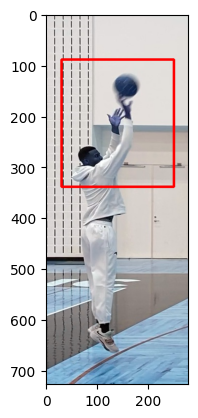

In [77]:
bbox = read_json('data/train/04d47186-9bd6-11ee-8660-ec5c68664d6f.json')
img = 'data/train/04d47186-9bd6-11ee-8660-ec5c68664d6f.jpg'
plot_image_with_bbox(img,bbox)

##### AUGMENT DATA USING ALBUMENTATION

In [78]:
augmentor = A.Compose([
    A.Resize(height=450,width=200),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(p=0.2)],
    bbox_params=A.BboxParams(format='albumentations',label_fields=['class_labels']))


In [80]:
img = cv2.imread('data/train/04d47186-9bd6-11ee-8660-ec5c68664d6f.jpg')
bbox = read_json('data/train/04d47186-9bd6-11ee-8660-ec5c68664d6f.json')
aug_shape = [img.shape[1],img.shape[0],img.shape[1],img.shape[0]]
aug_bbox= [np.divide(bbox,aug_shape)]
augmented_info = augmentor(image=img,bboxes=aug_bbox,class_labels=['positive'])

In [81]:
augmented_image = augmented_info['image']
augmented_bbox = augmented_info['bboxes'][0]

In [82]:
new_bbox_resized = np.array([
    augmented_bbox[0] * 200,
    augmented_bbox[1] * 450,
    augmented_bbox[2] * 200,
    augmented_bbox[3] * 450
]).astype('int').ravel()
new_bbox_resized

array([ 21,  55, 179, 210])

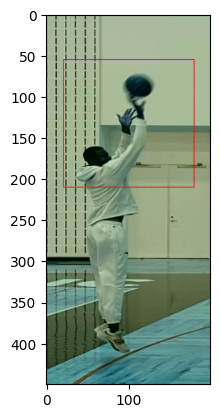

In [83]:
cv2.rectangle(augmented_image,
              (new_bbox_resized[0],new_bbox_resized[1]),
              (new_bbox_resized[2],new_bbox_resized[3]),
              (255,0,0))
plt.imshow(augmented_image)

In [84]:
data = {
    'image': Path('data/images'),
    'train': Path('data/train'),
    'test': Path('data/test')
}


In [85]:
def get_bbox_class(path):
    with open(path,'r') as f:
        json_file = json.load(f)
    bbox = json_file['shapes'][0]['points']
    label = json_file['shapes'][0]['label']
    return np.array(bbox).ravel(),label
    

In [86]:
folders = ['train','test']

for category in folders:
    category_path = Path('data')/f"{category}"
    original_image = [x for x in category_path.glob('*.jpg')]
    
    for image in original_image:
        img = cv2.imread(str(image))
        img_shape = img.shape
        number_of_augmented_images = 60
        image_json = image.with_suffix('.json')

        if image_json.is_file():
            try:    
                bbox,class_label = get_bbox_class(str(image_json))
            except:
                continue
        else:
            bbox = [0,0,0.000000001,0.000000001]
            class_label = 'negative'

        img_shape_for_aug = [img.shape[1],img.shape[0],img.shape[1],img.shape[0]]
        aug_bbox_input = [np.divide(bbox,img_shape_for_aug)]
        
        for i in range(number_of_augmented_images):
            new_augmented_image = augmentor(image=img,bboxes=aug_bbox_input,class_labels=[class_label])
            new_image = new_augmented_image['image']

            json_dict = {}
            json_dict['label'] = 0 if class_label == 'negative' else 1
            json_dict['bbox'] = new_augmented_image['bboxes'][0]

            filename_img = f"{str(image.stem)}_{i}.jpg"
            filename_json = f"{str(image.stem)}_{i}.json"
            augmented_image_path = os.path.join('aug_data',category,filename_img)
            augmented_json_path = os.path.join('aug_data',category,filename_json)

            cv2.imwrite(augmented_image_path,new_image)
            with open(augmented_json_path,'w') as f:
                json.dump(json_dict,f)

In [87]:
def read_my_json(path):
    with open(path,'r') as f:
        label = json.load(f)
    bbox = label['bbox']
    class_label = label['label']
    return bbox, class_label

def plot_aug_img_with_bbox(img,bbox):
    img = cv2.imread(str(img))
    bbox = np.array([
        bbox[0] * 200,
        bbox[1] * 450,
        bbox[2] * 200,
        bbox[3] * 450,
    ]).astype('int').ravel().tolist()
    cv2.rectangle(img,bbox[:2],bbox[2:],(255,0,0),2)
    plt.imshow(img)
    plt.show()
    

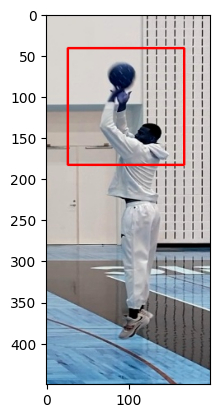

In [88]:
img = 'aug_data/train/0cda611b-9bd6-11ee-8482-ec5c68664d6f_1.jpg'
json_img = 'aug_data/train/0cda611b-9bd6-11ee-8482-ec5c68664d6f_1.json'
bbox,label = read_my_json(json_img)
plot_aug_img_with_bbox(img,bbox)


##### CREATE DATESETS FOR MODELS

In [89]:
def create_dataset(directory):
    img_file = tf.data.Dataset.list_files(os.path.join(directory,'*.jpg'),shuffle=False)
    decoded_image = img_file.map(read_images)

    json_file = tf.data.Dataset.list_files(os.path.join(directory,'*json'),shuffle=False)
    json_doc = json_file.map(lambda x: tf.py_function(json_read,[x],[tf.int32,tf.float32]))

    dataset = tf.data.Dataset.zip((decoded_image,json_doc))
    dataset = dataset.shuffle(5000)
    dataset = dataset.batch(8)
    dataset = dataset.prefetch(4)
    return dataset

def read_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    resized_img = tf.image.resize(img,(120,120))
    resized_img /= 255.0
    return resized_img


def json_read(x):
    with open(x.numpy(),'r') as f:
        label = json.load(f)
    bbox = label['bbox']
    class_label = label['label']
    return [class_label,bbox]

In [90]:
all_dataset = create_dataset('aug_data/train')

In [91]:
x = all_dataset.as_numpy_iterator()
x

In [92]:
y = x.next()
y

(array([[[[0.56209147, 0.56209147, 0.56209147],
          [0.5647059 , 0.5647059 , 0.5647059 ],
          [0.5596405 , 0.5596405 , 0.5596405 ],
          ...,
          [0.08937909, 0.13643792, 0.19395423],
          [0.08382353, 0.12843138, 0.19607843],
          [0.08218957, 0.12532683, 0.20081702]],
 
         [[0.5611111 , 0.5611111 , 0.5611111 ],
          [0.56078434, 0.56078434, 0.56078434],
          [0.5611111 , 0.5611111 , 0.5611111 ],
          ...,
          [0.101634  , 0.15130723, 0.19052285],
          [0.09460784, 0.14166667, 0.19558823],
          [0.08986928, 0.13692811, 0.19869281]],
 
         [[0.56421566, 0.56421566, 0.56421566],
          [0.56421566, 0.56421566, 0.56421566],
          [0.56421566, 0.56421566, 0.56421566],
          ...,
          [0.07630719, 0.12598042, 0.16519605],
          [0.075     , 0.12205882, 0.16911764],
          [0.07450981, 0.12156863, 0.16862746]],
 
         ...,
 
         [[0.75947714, 0.63398695, 0.43398693],
          [0.75294

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


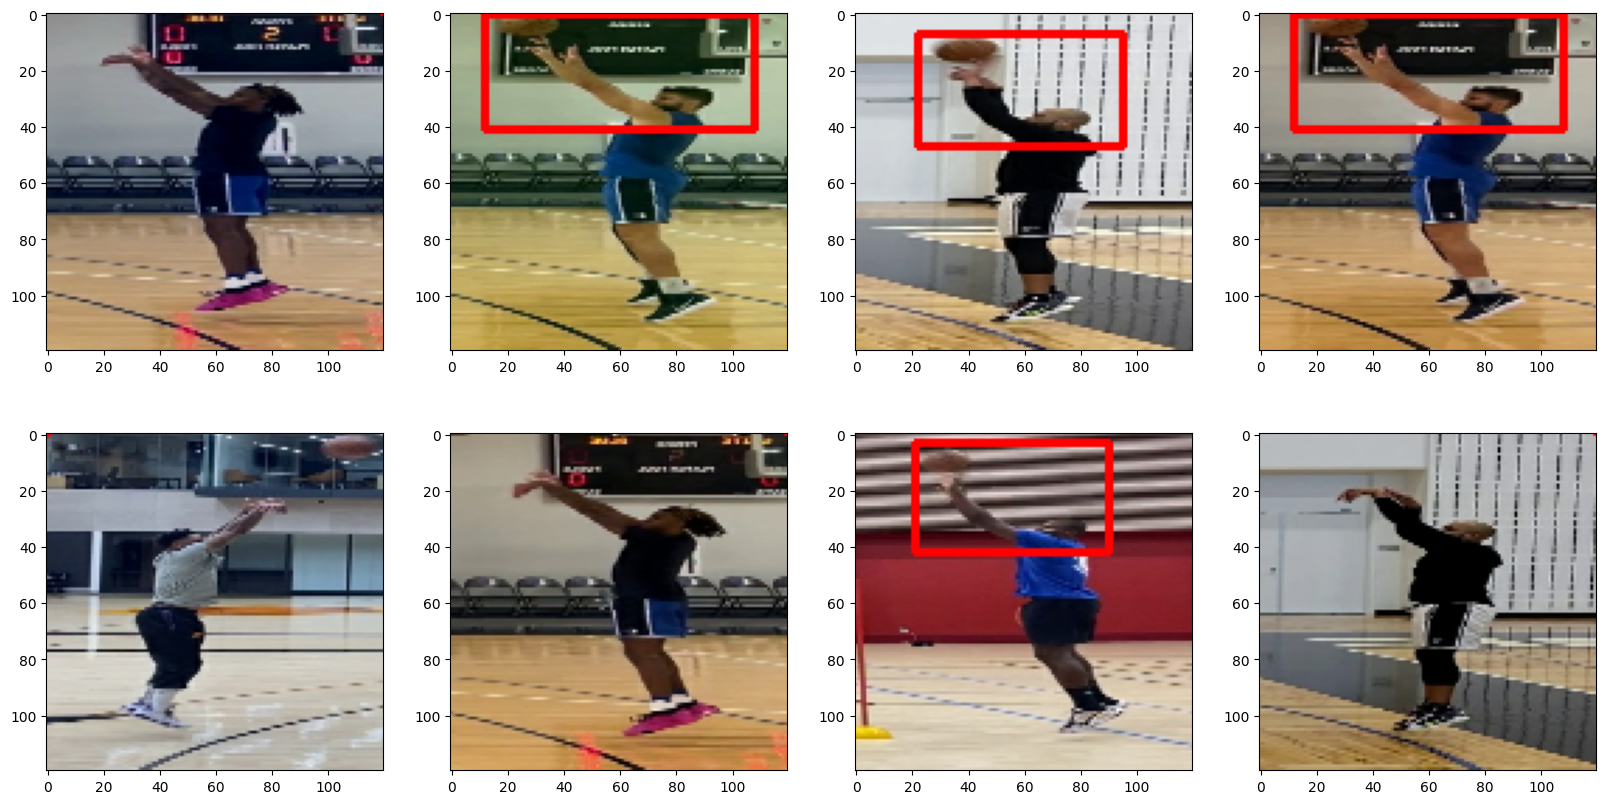

In [93]:
def display_image(z):
    fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,10))
    for i in range(8):
        row = i // 4
        col = i % 4
        img = z[0][i]
        bbox = z[1][1][i]
        cv2.rectangle(img,
                    tuple(np.multiply(bbox[:2],[120,120]).astype(int)),
                    tuple(np.multiply(bbox[2:],[120,120]).astype(int)),
                    (255,0,0),2)
        ax[row,col].imshow(img)

display_image(y)


In [94]:
train_dataset = create_dataset('aug_data/train')
test_dataset = create_dataset('aug_data/test')

##### BUILD MODEL AND DEFINE OPTIMIZERS,LOSS FUNCTION

In [95]:
from tensorflow.keras.layers import Input,GlobalMaxPool2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

##### we use the face detection model

In [96]:
def build_model():
    input = Input(shape=(120,120,3))
    vgg_layer = VGG16(include_top=False)(input)

    #classfication layer
    f1 = GlobalMaxPool2D()(vgg_layer)
    f2 = Dense(2048,activation='relu')(f1)
    class_layer = Dense(1,activation='sigmoid')(f2)


    #regression layer
    r1 = GlobalMaxPool2D()(vgg_layer)
    r2 = Dense(2048,activation='relu')(r1)
    reg_layer = Dense(4,activation='sigmoid')(r2)

    model = Model(inputs=input,outputs=[class_layer,reg_layer])
    return model

In [97]:
new_handcontact_detection = build_model()
new_handcontact_detection.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_1[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [98]:
batch_per_epoch = len(train_dataset)
lr_decay = (1/0.75-1)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0001,decay_rate=lr_decay,decay_steps=1000)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [99]:
def localization_loss(y_true,y_pred):
    #part 1 is the loss between the starting point of bounding box of y_true and y_pred
    part1 = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))

    #part 2 is the loss between the height and width of bbox of y_true and y_pred
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]

    part2 = tf.reduce_sum(tf.square(h_true - h_pred) + tf.square(w_true - w_pred))
    return part1 + part2

In [100]:
y_pred = new_handcontact_detection.predict(y[0])

1/1 [==============================] - 1s 1s/step


In [101]:
localization_loss(y[1][1],y_pred[1])

<tf.Tensor: shape=(), dtype=float32, numpy=11.462196>

In [102]:
localizationloss = localization_loss
classificationloss = tf.keras.losses.BinaryCrossentropy()

In [103]:
class Atshot(Model):
    def __init__(self,handballdect,**kwargs):
        super().__init__(**kwargs)
        self.handballdect = handballdect

    def compile(self,optimizer,classificationloss,localizationloss,**kwargs):
        super().compile(**kwargs)
        self.classificationloss = classificationloss
        self.localizationloss = localizationloss
        self.optimizer = optimizer

    def train_step(self,batch,**kwargs):
        X,y = batch

        with tf.GradientTape() as tape:
            label,bbox = self.handballdect(X,training=True)
            classloss = self.classificationloss(y[0],label)
            localloss = self.localizationloss(y[1],bbox)
            totalloss = localloss + 0.5*classloss
            gradient = tape.gradient(totalloss,self.handballdect.trainable_variables)
        optimizer.apply_gradients(zip(gradient,self.handballdect.trainable_variables))
        return {'totalloss':totalloss, 'classification':classloss, 'regressionloss':localloss}

    def test_step(self,batch,**kwargs):
        X,y = batch
        label,bbox = self.handballdect(X,training=False)
        classloss = self.classificationloss(y[0],label)
        localloss = self.localizationloss(y[1],bbox)
        totalloss = localloss + 0.5 * classloss
        return {'totalloss':totalloss, 'classification':classloss, 'regressionloss':localloss}
    
    def call(self,X,**kwargs):
        return self.handballdect(X,**kwargs)


In [104]:
model = Atshot(new_handcontact_detection)
model

In [105]:
model.compile(optimizer,classificationloss,localizationloss)

In [106]:
ypred = model.predict(y[0])
ypred

1/1 [==============================] - 2s 2s/step


[array([[0.65834486],
        [0.9999781 ],
        [0.40436837],
        [0.9999782 ],
        [0.4753911 ],
        [0.6346825 ],
        [0.1723723 ],
        [0.6925888 ]], dtype=float32),
 array([[0.67230374, 0.6049148 , 0.4313947 , 0.62552446],
        [0.9999991 , 1.        , 0.9994667 , 0.99991   ],
        [0.9999136 , 1.        , 0.999952  , 1.        ],
        [0.9999991 , 1.        , 0.9994672 , 0.9999088 ],
        [0.62287956, 0.650392  , 0.5748114 , 0.78125757],
        [0.67838657, 0.5938109 , 0.39558765, 0.65480083],
        [0.99968404, 1.        , 0.99993366, 1.        ],
        [0.5969351 , 0.4431064 , 0.4785241 , 0.63703644]], dtype=float32)]

In [107]:
logdir = 'log_contact'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [108]:
history = model.fit(train_dataset,epochs=40,callbacks=[tensorboard_callback])


Epoch 1/40
803/803 [==============================] - 2153s 3s/step - totalloss: 0.3871 - classification: 0.1019 - regressionloss: 0.3361
Epoch 2/40
803/803 [==============================] - 2193s 3s/step - totalloss: 0.0074 - classification: 8.4762e-05 - regressionloss: 0.0074
Epoch 3/40
803/803 [==============================] - 2380s 3s/step - totalloss: 0.0059 - classification: 4.7755e-05 - regressionloss: 0.0059
Epoch 4/40
803/803 [==============================] - 2191s 3s/step - totalloss: 0.0052 - classification: 3.2950e-05 - regressionloss: 0.0052
Epoch 5/40
803/803 [==============================] - 2710s 3s/step - totalloss: 0.0049 - classification: 2.6374e-05 - regressionloss: 0.0049
Epoch 6/40
803/803 [==============================] - 3020s 4s/step - totalloss: 0.0047 - classification: 2.3179e-05 - regressionloss: 0.0047
Epoch 7/40
803/803 [==============================] - 2496s 3s/step - totalloss: 0.0047 - classification: 2.1255e-05 - regressionloss: 0.0046
Epoch 8/40

KeyboardInterrupt: 

In [109]:
y_pred = model.predict(y[0])
y_pred

1/1 [==============================] - 1s 955ms/step


[array([[1.5304431e-09],
        [3.0020099e-06],
        [0.0000000e+00],
        [2.9657454e-06],
        [2.9161003e-01],
        [8.1568583e-09],
        [0.0000000e+00],
        [3.7725324e-13]], dtype=float32),
 array([[9.9981588e-01, 3.6410664e-05, 9.9970996e-01, 6.2015126e-05],
        [2.7293529e-06, 5.6433892e-21, 4.0844965e-01, 4.3422424e-16],
        [1.0000000e+00, 0.0000000e+00, 9.9991071e-01, 0.0000000e+00],
        [2.7211945e-06, 5.4479161e-21, 4.1000596e-01, 4.2926687e-16],
        [4.0554095e-04, 1.1595119e-04, 3.5332892e-02, 1.8751856e-03],
        [9.9990368e-01, 7.3989264e-05, 9.9984896e-01, 9.5255644e-05],
        [8.5659987e-01, 0.0000000e+00, 8.9696157e-01, 0.0000000e+00],
        [9.9997383e-01, 1.6509100e-06, 9.9997813e-01, 1.2263532e-06]],
       dtype=float32)]

In [110]:
y[1]

(array([0, 1, 1, 1, 0, 0, 1, 0]),
 array([[1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.71821303e-12],
        [1.06015414e-01, 2.96026981e-03, 9.01441693e-01, 3.46768975e-01],
        [1.89335153e-01, 6.33739382e-02, 7.94934988e-01, 3.94001484e-01],
        [1.06015414e-01, 2.96026981e-03, 9.01441693e-01, 3.46768975e-01],
        [0.00000000e+00, 0.00000000e+00, 3.54609940e-12, 1.60513649e-12],
        [1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.70648467e-12],
        [1.82367146e-01, 2.75027510e-02, 7.57246375e-01, 3.52035195e-01],
        [1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.63398689e-12]],
       dtype=float32))

##### LOAD MODEL AND TEST

In [111]:
test_x = test_dataset.as_numpy_iterator()
x = test_x.next()
x

(array([[[[0.15506536, 0.15359478, 0.12761438],
          [0.16568628, 0.16176471, 0.14460784],
          [0.18611111, 0.16879086, 0.1377451 ],
          ...,
          [0.61879086, 0.5756536 , 0.5050654 ],
          [0.61715686, 0.5740196 , 0.5034314 ],
          [0.61715686, 0.5740196 , 0.5034314 ]],
 
         [[0.14411765, 0.14183007, 0.11699346],
          [0.13970588, 0.13970588, 0.09362745],
          [0.16895424, 0.14852941, 0.11830065],
          ...,
          [0.62352943, 0.5803922 , 0.50980395],
          [0.62352943, 0.5803922 , 0.50980395],
          [0.6173203 , 0.57418305, 0.5035948 ]],
 
         [[0.11503267, 0.11895424, 0.0988562 ],
          [0.09950981, 0.10343137, 0.08382353],
          [0.10245099, 0.10539217, 0.08398693],
          ...,
          [0.62581706, 0.5826798 , 0.5120915 ],
          [0.62352943, 0.5803922 , 0.50980395],
          [0.62352943, 0.5803922 , 0.50980395]],
 
         ...,
 
         [[0.81209147, 0.56928104, 0.28300652],
          [0.77745

In [112]:
y = model.predict(x[0])

1/1 [==============================] - 1s 713ms/step


In [115]:
(y[0] > 0.5).astype(int)

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [116]:
x[1][0]

array([1, 1, 1, 0, 0, 0, 0, 0])

[0.15875238 0.01573255 0.76141083 0.2707062 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.20235349 0.11001172 0.7771348  0.38288578]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.22299911 0.06873907 0.8549338  0.40082565]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.01094947 0.01053496 0.0472145  0.05333891]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9.9999493e-01 9.3030485e-07 9.9999607e-01 1.0587092e-06]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.90541106 0.01117659 0.9815212  0.07899987]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00301429 0.00240025 0.00492553 0.00390546]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.92370844 0.01013483 0.98456556 0.06942855]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


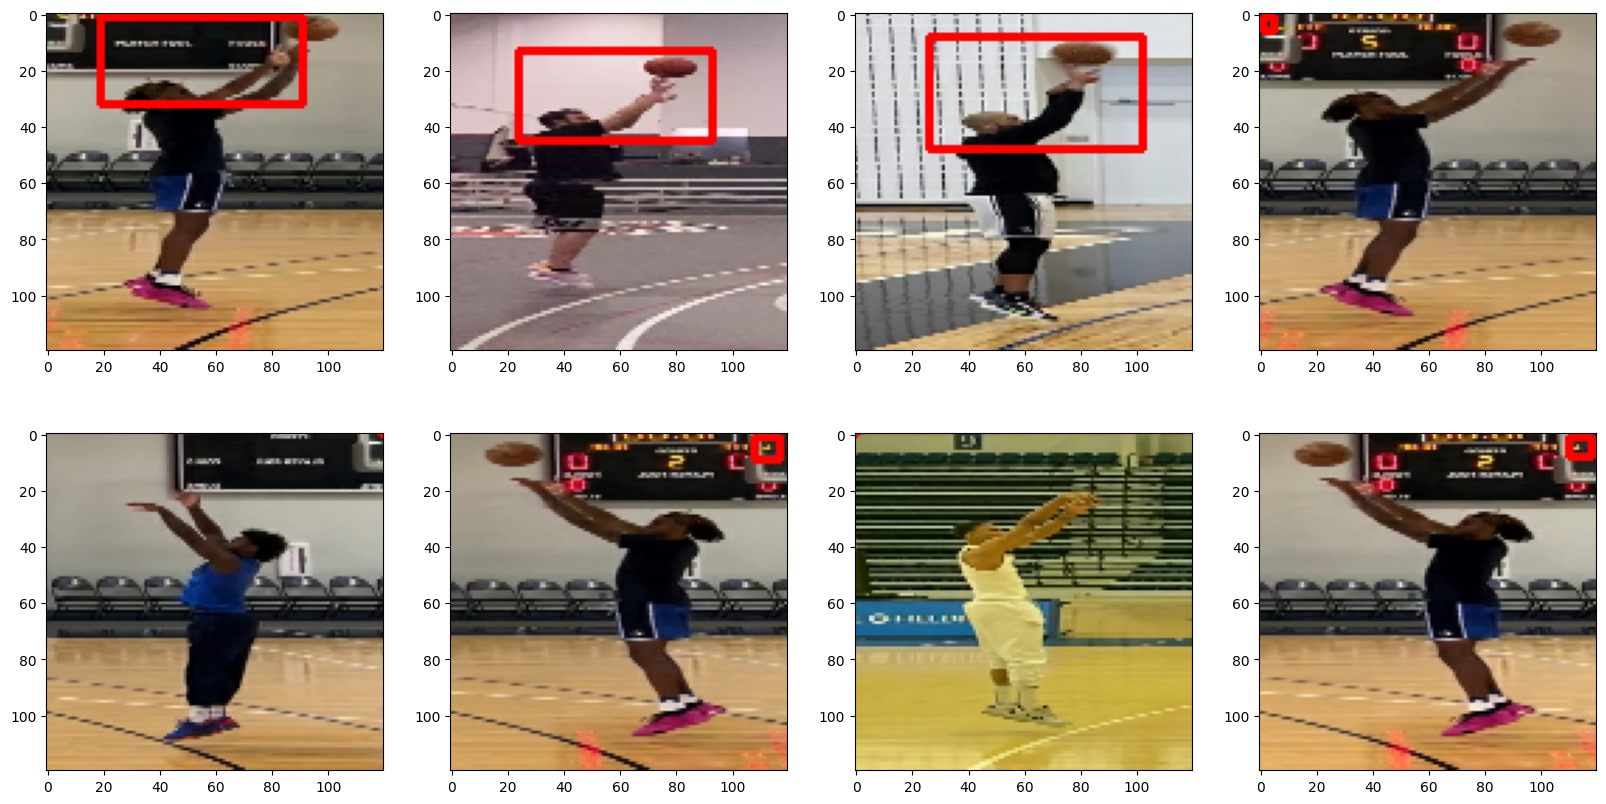

In [117]:
def display_image(x,y):
    fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,10))
    for i in range(8):
        row = i // 4
        col = i % 4
        img = x[i]
        bbox = y[1][i]
        print(bbox)
        cv2.rectangle(img,
                    tuple(np.multiply(bbox[:2],[120,120]).astype(int)),
                    tuple(np.multiply(bbox[2:],[120,120]).astype(int)),
                    (255,0,0),2)
        ax[row,col].imshow(img)

display_image(x[0],y)



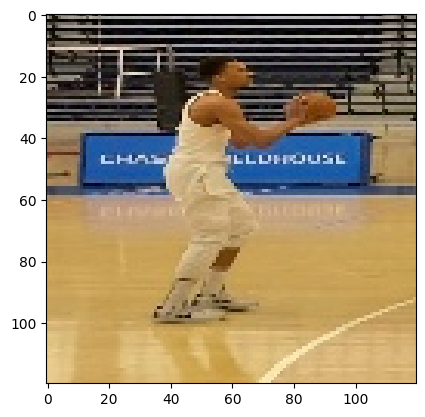

In [120]:
img = cv2.imread('inspect/5f1e1c68-9d1a-11ee-a3d8-ec5c68664d6f.jpg')
plt.imshow(img)

In [124]:
y_pred = m.predict(np.expand_dims(img,axis=0))
y_pred

1/1 [==============================] - 1s 574ms/step


[array([[0.]], dtype=float32),
 array([[7.4327208e-26, 0.0000000e+00, 3.1006449e-09, 0.0000000e+00]],
       dtype=float32)]

In [122]:
new_handcontact_detection.save('contact_detection.h5')

In [123]:
m = load_model('contact_detection.h5')